## The Goal: Compute CTP and HI_low over CONUS at 12 UTC 
<br>
<b>Author:</b> Meg D. Fowler 
<br>
<b>Date:</b>   2 Sept 2020 
<br><br>
<b>Short description:</b> Building off of lots of scratch work in CTP-HI_low_CONUS_scratch.ipynb, uses a python version of the fortran script to compute CTP and HI_low at each point over CONUS. The .py version's slightly more sluggish (~18s for 5k profiles as opposed to ~12s), but it's easy to read and understand. 
<br>

In [1]:
# Import libraries 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import time 
import regionmask
from CTP_hilow import CTP_hilow 

# Plotting utils 
import matplotlib.pyplot as plt 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data

In [2]:
# Set file names 
mainDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/hrSim_CONUS/'

fileQ1 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979_hrQ-UTCsel.nc'
fileQ2 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrQ-UTCsel.nc'
fileQ3 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1981_hrQ-UTCsel.nc'

fileT1 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979_hrT-UTCsel.nc'
fileT2 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrT-UTCsel.nc'
fileT3 = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1981_hrT-UTCsel.nc'

fileP  = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrP-levels-UTCsel.nc'

filePS  = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrPS-UTCsel.nc'
fileT2m = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrTREFHT-UTCsel.nc'
fileQ2m = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrQREFHT-UTCsel.nc'
fileSH  = mainDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrSHFLX-UTCsel.nc'


In [3]:
# Read in files that have profiles and concat into one DS
Q_1979 = xr.open_dataset(fileQ1, decode_times=True)
Q_1980 = xr.open_dataset(fileQ2, decode_times=True)
Q_1981 = xr.open_dataset(fileQ3, decode_times=True)
Q_full = xr.concat([Q_1979, Q_1980,Q_1981], dim="time")
print('Done with Q...')

T_1979 = xr.open_dataset(fileT1, decode_times=True)
T_1980 = xr.open_dataset(fileT2, decode_times=True)
T_1981 = xr.open_dataset(fileT3, decode_times=True)
T_full = xr.concat([T_1979, T_1980,T_1981], dim="time")
print('Done with T... ')

P_all  = xr.open_dataset(fileP,  decode_times=True)
print('Done with P...')


Done with Q...
Done with T... 
Done with P...


In [4]:
# Now read in files (all years, sfc only)
PS  = xr.open_dataset(filePS,  decode_times=True)
T2m = xr.open_dataset(fileT2m, decode_times=True)
Q2m = xr.open_dataset(fileQ2m, decode_times=True)
SH  = xr.open_dataset(fileSH, decode_times=True)


In [5]:
# Assemble into single dataset (xarray)
ds_Full = Q_full
ds_Full['Tlev'] = (('time','lev','lat','lon'), T_full.T)
ds_Full['Plev'] = (('time','lev','lat','lon'), P_all.PRESSURE)
ds_Full['PS'] = (('time','lat','lon'), PS.PS)
ds_Full['T2m'] = (('time','lat','lon'), T2m.TREFHT)
ds_Full['Q2m'] = (('time','lat','lon'), Q2m.QREFHT)
ds_Full['SHF'] = (('time','lat','lon'), SH.SHFLX)


In [6]:
ds_Full

<xarray.Dataset>
Dimensions:  (lat: 43, lev: 32, lon: 65, time: 5475)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon      (lon) float64 220.0 221.2 222.5 223.8 ... 296.2 297.5 298.8 300.0
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 57.02 57.96 58.9 59.84
  * time     (time) object 1979-01-01 10:00:00 ... 1981-12-31 14:00:00
Data variables:
    Q        (time, lev, lat, lon) float32 2.7808608e-06 ... 0.0025378529
    UTC_hr   (time) float32 10.0 11.0 12.0 13.0 14.0 ... 11.0 12.0 13.0 14.0
    UTC_day  (time) float32 1.0 1.0 1.0 1.0 1.0 2.0 ... 31.0 31.0 31.0 31.0 31.0
    UTC_mon  (time) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0 12.0 12.0
    UTC_yr   (time) float32 1979.0 1979.0 1979.0 1979.0 ... 1981.0 1981.0 1981.0
    Tlev     (time, lev, lat, lon) float32 250.42609 250.28642 ... 270.61188
    Plev     (time, lev, lat, lon) float32 364.34656 364.34656 ... 97498.84
    PS       (time, lat, lon) float32 102068.03 102079.78 ... 98192.0 98230.06
    T2m      (time, lat, lon) float32 293.90747 293.6864 ... 271.09384 271.51926
    Q2m      (time, lat, lon) float32 0.011486784 0.011303191 ... 0.0027535888
    SHF      (time, lat, lon) float32 39.52112 41.92458 ... 26.336369 28.1356
Attributes:
    creation_date:  Mon Aug 31 17:46:50 MDT 2020
    Conventions:    None
    source_file:    /glade/scratch/mdfowler/processedData/f.e21.FHIST_BGC.f09...
    title:          NCL used to get UTC; 4 early morning hours saved out.

In [6]:
# Pick out 12 UTC only 
ds_utc12 = ds_Full.where( ds_Full.UTC_hr==12.0 , drop=True )


In [7]:
# Define dimensions 
nLat  = len(ds_utc12.lat)
nLon  = len(ds_utc12.lon)
nTime = len(ds_utc12.time)


## Compute CTP and HI_low 

In [16]:
# Define empty arrays to save things into 
CTP_all   = np.full([nTime,nLat,nLon], np.nan)
HIlow_all = np.full([nTime,nLat,nLon], np.nan)

t_All = time.time()

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nTime):
            
            # Pick out specific point and time period 
            DF = ds_Full.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()
            
            # Flip order of levels so that surface comes first (required for function)
            DF = DF.reindex(index=DF.index[::-1])
            
            # Compute CTP and HI_low
            CTP_all[iT,iLat,iLon], HIlow_all[iT,iLat,iLon] = CTP_hilow(DF['Tlev'].values, DF['Q'].values, 
                                                                   DF['Plev'].values, DF['T2m'].values[0], 
                                                                   DF['Q2m'].values[0], DF['PS'].values[0])
    print('Done with lat %i of %i ' % (iLat, nLat))
        

print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_All))


Done with lat 0 of 43 
Done with lat 1 of 43 
Done with lat 2 of 43 
Done with lat 3 of 43 
Done with lat 4 of 43 
Done with lat 5 of 43 
Done with lat 6 of 43 
Done with lat 7 of 43 
Done with lat 8 of 43 
Done with lat 9 of 43 
Done with lat 10 of 43 
Done with lat 11 of 43 
Done with lat 12 of 43 
Done with lat 13 of 43 
Done with lat 14 of 43 
Done with lat 15 of 43 
Done with lat 16 of 43 
Done with lat 17 of 43 
Done with lat 18 of 43 
Done with lat 19 of 43 
Done with lat 20 of 43 
Done with lat 21 of 43 
Done with lat 22 of 43 
Done with lat 23 of 43 
Done with lat 24 of 43 
Done with lat 25 of 43 
Done with lat 26 of 43 
Done with lat 27 of 43 
Done with lat 28 of 43 
Done with lat 29 of 43 
Done with lat 30 of 43 
Done with lat 31 of 43 
Done with lat 32 of 43 
Done with lat 33 of 43 
Done with lat 34 of 43 
Done with lat 35 of 43 
Done with lat 36 of 43 
Done with lat 37 of 43 
Done with lat 38 of 43 
Done with lat 39 of 43 
Done with lat 40 of 43 
Done with lat 41 of 43 
Do

In [17]:
# Save the array with CTP 
saveDir  = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.CTP_CONUS_12utc.p' 

pickle.dump( CTP_all, open( saveDir+saveFile, "wb" ), protocol=4 )

In [18]:
# Save the array with CTP 
saveDir  = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
saveFile = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HIlow_CONUS_12utc.p' 

pickle.dump( HIlow_all, open( saveDir+saveFile, "wb" ), protocol=4 )

In [20]:
# How long was compute time in hours?
10752.282/60/60


2.9867449999999995

## Analysis time, yay!! 

In [8]:
# Read in from pickle files 
saveDir        = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
CTP_fileName   = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.CTP_CONUS_12utc.p'
HIlow_fileName = saveDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.HIlow_CONUS_12utc.p'

CTP_all   = pickle.load(open(CTP_fileName, "rb"))
HIlow_all = pickle.load(open(HIlow_fileName, "rb"))


In [60]:
# Probably could've done this first... But let's use just days from JJA 
iMon = np.where((ds_utc12.UTC_mon.values>=6) & (ds_utc12.UTC_mon.values<=8) )[0]

CTP_jja = CTP_all[iMon,:,:]
HI_jja  = HIlow_all[iMon,:,:]

# Going to also isolate the years here 
yrs_jja = ds_utc12.UTC_yr.values[iMon]


In [10]:
# So define dimensions again 
nTime = np.shape(CTP_jja)[0]
nLat  = np.shape(CTP_jja)[1]
nLon  = np.shape(CTP_jja)[2]


In [71]:
# Could've done this before too - apply land mask 
dataDir  = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/hrSim_CONUS/'
fileName = 'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.clm2.h0.1980-01.nc'
data = xr.open_dataset(dataDir+fileName, decode_times=False)

# Read in land mask and limit to lat/lon used here
landMask = data.landmask.values

iLat = np.where((data.lat.values>=np.min(ds_utc12.lat.values)) & (data.lat.values<=np.max(ds_utc12.lat.values)))[0]
iLon = np.where((data.lon.values>=np.min(ds_utc12.lon.values)) & (data.lon.values<=np.max(ds_utc12.lon.values)))[0]

landMask_sel = landMask[iLat,:]
landMask_sel = landMask_sel[:,iLon]

CTP_jja = CTP_jja*landMask_sel
HI_jja  = HI_jja*landMask_sel


<br>
To start, I'm going to apply the fairly rigid classification scheme from Findell and Eltahir (2003). Note though that there are valid reasons for *not* doing that and following something more flexible and data-dependent, like Ferguson and Wood (2011). We should apply that later and check for differences.
<br>

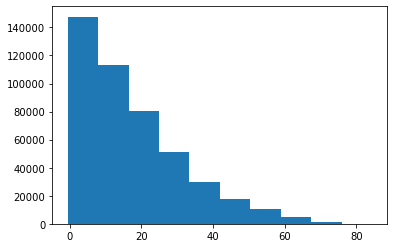

In [67]:
# Check distribution of HI_low
#   FE03 keeps HI in units of ˚C, but ours in K. 
#   In retrospect though, since it's just a measure of the difference in T and Td between levels, 
#   that *difference* should be unaffected by which units of temperature were used (for ˚C vs. K, at least). 

plt.hist(HI_jja.reshape([nTime*nLat*nLon,1]))
plt.show()

# And that distribution looks quite reasonable! See FE03_part2 Fig. 4 for example. 

In [74]:
# Going to make a key for classification: 
#  1 -- Atmospherically controlled (too stable for rain)
#  2 -- Atmospherically controlled (too dry for rain)
#  3 -- Atmospherically controlled (rainfall likely regardless of soil moisture)
#  4 -- Wet soil advantage 
#  5 -- Dry soil advantage 
#  6 -- Transition region 
#  7 -- Shallow clouds likely over wet, but no rain. This one doesn't really count. 

regime_jja = np.full([nTime, nLat, nLon], np.nan)

# Look at each profile individually 
for iT in range(nTime):
    for iLat in range(nLat):
        for iLon in range(nLon):
            
            CTP_point = CTP_jja[iT, iLat, iLon]
            HI_point  = HI_jja[iT, iLat, iLon]
            
            # First, let's pick out soundings that are atmospherically controlled (too stable)
            if CTP_point<0: 
                regime_jja[iT, iLat, iLon] = 1
            # Atmospherically controlled and too dry for rain    
            elif ( (CTP_point>=0) & (HI_point>=15) ):
                regime_jja[iT,iLat,iLon] = 2
            # Atmospherically controlled and lead to rain over any soil moisture
            elif ( (CTP_point>=0) & (HI_point<5) ):
                regime_jja[iT,iLat,iLon] = 3
            # Wet soil advantage for precipitation 
            elif ((CTP_point>=0) & (HI_point>=5) & (HI_point<10) ):
                regime_jja[iT,iLat,iLon] = 4
            # Dry soil advantage for precipitation     
            elif ((CTP_point>=200) & (HI_point>=10) & (HI_point<15) ):
                regime_jja[iT,iLat,iLon] = 5
            # Transition region 
            elif ((CTP_point>=50) & (CTP_point<200) & (HI_point>=10) & (HI_point<15) ):
                regime_jja[iT,iLat,iLon] = 6
            # Section just to catch shallow clouds likely over wet; no rain expected in this category though
            elif ((CTP_point<50) & (HI_point>=10) & (HI_point<15) ):
                regime_jja[iT,iLat,iLon] = 7
            # Add a catch-other regions option (ruh-roh section)
            else: 
                regime_jja[iT,iLat,iLon] = 8
                
regime_jja = regime_jja*landMask_sel


In [35]:
# Define array of labels for each category 
labels = ['Atm', 'Atm', 'Atm','Wet SM', 'Dry SM','Transition','No rain']

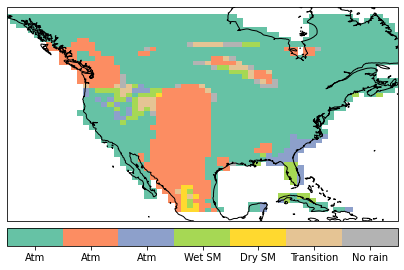

In [75]:
# Set up figure to plot a map of regime (choose a random day)
fig, ax1 = plt.subplots(1,1, figsize=(7, 5), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Set US extent
ax1.set_extent([220,300,18,55])

cmap = plt.get_cmap('Set2', 7)

contour_plot = ax1.pcolormesh(ds_utc12.lon,ds_utc12.lat,regime_jja[100,:,:],
                                    vmin=1,
                                    vmax=8,
                                    cmap=cmap)
ax1.coastlines()
# Add colorbar
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.07, ax_position.width, 0.05])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_ticks(np.linspace(1.5,7.5,7))
cbar.set_ticklabels(labels)



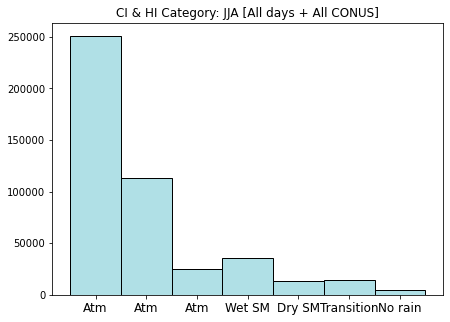

In [76]:
# Histogram of all gridcells and all days 

fig, ax1 = plt.subplots(1,1, figsize=(7, 5))

ax1.hist(regime_jja.reshape([nTime*nLat*nLon, 1]), bins=[1,2,3,4,5,6,7,8], 
         align='left',
         edgecolor='k',
         color = 'powderblue')

ax1.set_title('CI & HI Category: JJA [All days + All CONUS]')

ax1.set_xticks(np.arange(1,8))
ax1.set_xticklabels(labels,fontsize=12)
plt.show()


### Follow methods of FE03_Part2 to classify each location by amount of time spent in each regime

Based on Findell and Eltahir (2003; Part 2), the organization should be as follows for each station (gridcell in our case) and each summer): 
* If 80%+ of days are atmospherically controlled, station is labeled as atmo controlled for the summer <br><br>
* <b>Level 1 options (< 80% of days atmo. controlled): </b>
* ---- Positive feedback (wet soil advantage): If more than 50% of the remaining days (those not atmo. controlled) are wet-soil advantage.
* ---- Negative feedback (dry soil advantage): If more than 50% of remaining days fall in dry soil advantage. 
* ---- Transitional station: If more than 50% of remaining days are in the transition regime. <br><br>
* <b> Level 2 options (<80% of days atmo controlled; <50% of remaining days fall into one category) </b>
* ---- Positive feedback (wet soil advantage): less than 20% of days not atmo. controlled fall in dry soil advantage.
* ---- Negative feedback (dry soil advantage): less than 20% of days not atmo. controlled fall into wet soil advantage. 
* ---- Transitional: Whatever's left after above filtering. 
<br><br>

In [77]:
# Simplify regime scheme so that any atmosphere-controlled day has same value:
regime_Simple                  = regime_jja.copy()
regime_Simple[regime_Simple<4] = 1


In [78]:
# Now separate each year... 
regimeSimple_yearly = np.full([3, 92, nLat, nLon], np.nan)  # Split the time dimension up to be year x JJA-days x lat x lon

regimeSimple_yearly[0,:,:,:] = regime_Simple[np.where(yrs_jja==1979)[0],:,:]
regimeSimple_yearly[1,:,:,:] = regime_Simple[np.where(yrs_jja==1980)[0],:,:]
regimeSimple_yearly[2,:,:,:] = regime_Simple[np.where(yrs_jja==1981)[0],:,:]


In [133]:
# Now let's classify each grid point per summer 
# New key: 
#    0 ('A')  -- Atmo controlled 
#    1 ('W1') -- Level 1 wet soil advantage 
#    2 ('D1') -- Level 1 dry soil advantage
#    3 ('T1') -- Level 1 transitional regime
#    4 ('W2') -- Level 2 wet soil advantage
#    5 ('D2') -- Level 2 dry soil advantage 
#    6 ('T2') -- Level 2 transitional regime 

# Define empty array to house classification by summer 
summerClass = np.full([3, nLat, nLon], np.nan)

# There are 92 days in JJA each year. So this is where we start for getting percentages 
allDays = 92
atmoCutoff = round(allDays*0.8)

for iYr in range(3):
    for iLat in range(nLat):
        for iLon in range(nLon):
            yrData = regimeSimple_yearly[iYr,:,iLat,iLon]
            
            # Find percent of days atmospherically controlled 
            iAtmo = np.where(yrData==1)[0]
            
            if len(iAtmo) >= atmoCutoff:           # Easy: atmospherically controlled summer and grid point 
                summerClass[iYr,iLat,iLon] = 0
                
            else:                                  # Next step of processing: Is grid point level 1? 
                restOfDays = yrData[yrData>1]      # Isolate the days that aren't atmospherically controlled 
                nRestDays  = len(restOfDays)       # Number of days left to consider 
                
                lev1cutoff = round(nRestDays*0.5)  # Number of days needed to be classified as level one
                lev2cutoff = round(nRestDays*0.2)  # Number of days for classifying level two 
                
                # Get number of remaining days falling into each category 
                iWet        = np.where(restOfDays==4)
                iDry        = np.where(restOfDays==5)
                iTransition = np.where(restOfDays==6)
                
                # Assign level 1 classifications 
                if len(iWet)>=lev1cutoff: 
                    summerClass[iYr,iLat,iLon] = 1
                elif len(iDry)>=lev1cutoff:
                    summerClass[iYr,iLat,iLon] = 2
                elif len(iTransition)>=lev1cutoff:
                    summerClass[iYr,iLat,iLon] = 3
                    
                # If not the case, let's go into level 2 classifications 
                else:
                    if len(iDry)<lev2cutoff:
                        summerClass[iYr,iLat,iLon] = 4
                    elif len(iWet)<lev2cutoff:
                        summerClass[iYr,iLat,iLon] = 5
                    else: 
                        summerClass[iYr,iLat,iLon] = 6
                
    summerClass[iYr,:,:] = summerClass[iYr,:,:]*landMask_sel
    

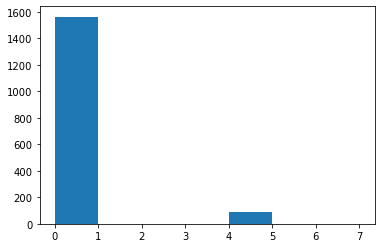

In [136]:
plt.hist(summerClass[0,:,:].reshape([nLat*nLon,1]),bins=[0,1,2,3,4,5,6,7])
plt.show()
         

In [118]:
# Define array of labels for each category 
labels = ['A', 'W1', 'D1','T1', 'W2','D2','T2']


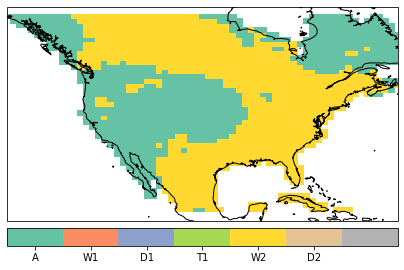

In [135]:
# Set up figure to plot a map of regime (choose a random day)
fig, ax1 = plt.subplots(1,1, figsize=(7, 5), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Set US extent
ax1.set_extent([220,300,18,55])

cmap = plt.get_cmap('Set2', 7)

contour_plot = ax1.pcolormesh(ds_utc12.lon,ds_utc12.lat,summerClass[2,:,:],
                                    vmin=0,
                                    vmax=7,
                                    cmap=cmap)
ax1.coastlines()
# Add colorbar
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.07, ax_position.width, 0.05])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_ticks(np.linspace(0.5,5.5,6))
cbar.set_ticklabels(labels)



Let's try a similar system, but since we only have three years let's look at 80% of all days vs. >50% of all JJA days, etc. 